In [1]:
import sys 
sys.path.append('../')

import torch
import matplotlib.pyplot as plt 
from einops import repeat

from src.dd_gmg import DD_GMG1D
from src.green_net import GreenNet1D
from src.model import MLP
from src.utils import rl2_error
torch.set_printoptions(linewidth=120)

In [2]:
def Logarithm(pts):
    x = pts[...,0]
    y = pts[...,1]
    return torch.nan_to_num(torch.log((x-y).abs()), neginf=-8)

In [3]:
n = 13
device = torch.device('cuda:0')
model = GreenNet1D(n=n, kernel=Logarithm, device=device, sub_num=5)
F = torch.squeeze(1 - model.grid.x_h**2)
F = repeat(F, 'n -> n b', b=64)

In [4]:
model.eval_K()
K_full = model.K_hh

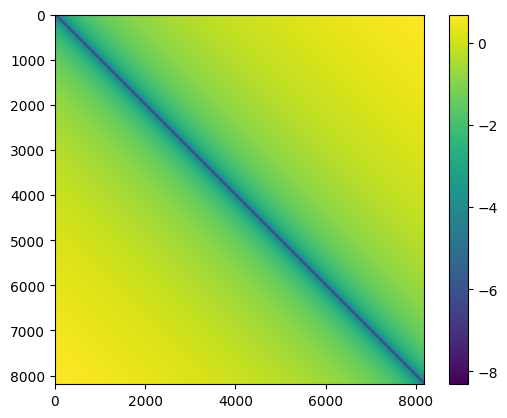

In [5]:
plt.imshow(K_full.cpu().reshape(2**n+1, 2**n+1))
plt.gca().set_aspect('equal')
plt.colorbar()

In [6]:
U_full = model.full_kint(F)
print(U_full.shape)

torch.Size([8193, 64])


In [7]:
# plt.subplot(121)
# plt.plot(model.grid.x_h, F[:,0], '-r')
# plt.title('input function F')
# plt.subplot(122)
# plt.plot(model.grid.x_h, U_full[:,0], '-b')
# plt.title('output function U')

# Digonal Dominant Multi-Grid

influence of level of coarse: `k`

In [8]:
m = 0
for k in [1, 3, 5, 7]:
    dd_gmg = DD_GMG1D(n,m,k,Logarithm,device)
    dd_gmg.restrict_ml_f(F)
    dd_gmg.eval_ml_K()
    U_dd = dd_gmg.ml_kint()
    print('k {:d} - m {:d} - rl2 {:.4e}'.format(k, m, rl2_error(U_dd.T, U_full.T)))

k 1 - m 0 - rl2 1.0664e-04
k 3 - m 0 - rl2 2.1267e-04
k 5 - m 0 - rl2 6.0817e-03
finest grid : 8193
coarest grid : 65
too coarse warning
k 7 - m 0 - rl2 4.7692e-02


influence of correction range : `c`

In [26]:
k = 5

for m in [0, 1, 3, 7, 15, 31, 65]:
    dd_gmg = DD_GMG1D(n,m,k,Logarithm,device)
    dd_gmg.restrict_ml_f(F)
    dd_gmg.eval_ml_K()
    U_dd = dd_gmg.ml_kint()

    print('k {:d} - m {:d} - rl2 {:.4e}'.format(k, m, rl2_error(U_dd.T, U_full.T)))

k 5 - m 0 - rl2 6.0817e-03
k 5 - m 1 - rl2 2.5531e-03
k 5 - m 3 - rl2 7.3453e-04
k 5 - m 7 - rl2 2.9205e-04
k 5 - m 15 - rl2 1.2226e-04
k 5 - m 31 - rl2 4.8421e-05
k 5 - m 65 - rl2 1.7781e-05


In [30]:
8193*256 / (8193*8193)

0.031246185768338826

In [10]:
# from tqdm import trange
# import numpy as np
# from src.ops import interp1d_cols, interp1d_rows

In [11]:
# k = 5
# m = 6
# dd_gmg = DD_GMG1D(n,m,k,Logarithm,device)
# dd_gmg.restrict_ml_f(F)
# dd_gmg.eval_ml_K()
# U_dd = dd_gmg.ml_kint()
# print(rl2_error(U_dd.T, U_full.T).numpy())

In [12]:
# grid_H = dd_gmg.ml_grids[-1]
# K_HH = dd_gmg.K_HH

In [13]:
# grid_h = dd_gmg.ml_grids[0]
# nh = grid_h.nh
# grid_h.init_grid_hh()
# K_hh = Logarithm(grid_h.x_hh).reshape(nh, nh)
# coords_ij = dd_gmg.ml_grids[0].coords_ij
# mask_ij = dd_gmg.ml_grids[0].mask_ij
# K_ij = K_hh[coords_ij[...,0], coords_ij[...,1]] * mask_ij

In [14]:
# coords_IJ = dd_gmg.ml_grids[-1].coords_ij
# mask_IJ = dd_gmg.ml_grids[-1].mask_ij
# K_IJ = K_HH[coords_IJ[...,0], coords_IJ[...,1]] * mask_IJ
# l=1
# nh = dd_gmg.ml_grids[-1-l].nh
# hh = dd_gmg.ml_grids[-1-l].hh
            
# # local evaluation and assemblation
# K_local_even, K_local_odd = dd_gmg.K_locals[l-1]
# K_ij_ = dd_gmg.local_assemble_K(K_IJ, K_local_even, K_local_odd)
# K_2Ij = K_ij_[::2]
                
# # local kernel interpolation
# K_local_even_, K_local_odd_ = dd_gmg.local_interp_K(K_IJ, K_2Ij)

# _, coords_even, mask_even = dd_gmg.pts_local[l-1][0]
# _, coords_odd, mask_odd = dd_gmg.pts_local[l-1][1]

K_band correctness

In [15]:
# K_hh

In [16]:
# K_2Ij

K_even Correctness

In [17]:
# K_hh[::2][:,1::2]

In [18]:
# K_local_even

K_even Interp Correctness

In [19]:
# interp1d_cols(K_HH[None,None])[0,0][:,1::2]

In [20]:
# K_local_even_

K_odd Correctness

In [21]:
# K_hh[1::2]

In [22]:
# K_local_odd

K_odd Interp

In [23]:
# (K_hh[::2][:-1] + K_hh[::2][1:])/2

In [24]:
# K_local_odd_